<a href="https://colab.research.google.com/github/quillaur/data_learning/blob/main/data_science/natural_language_processing/nlp_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data downloaded from https://www.kaggle.com/competitions/commonlitreadabilityprize/data?select=train.csv

Nice notebook: [CommonLit Readability Prize: EDA + Baseline](https://www.kaggle.com/code/ruchi798/commonlit-readability-prize-eda-baseline#Baseline-model-%E2%9A%99%EF%B8%8F)

Potential librairies:
* [Textstat](https://pypi.org/project/textstat/) => use these metrics to train a classical regressor ?


In [72]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [73]:
df = pd.read_csv("/content/train.csv.zip")

In [74]:
df.drop(["id", "url_legal", "license"], axis=1, inplace=True)

In [75]:
df.head()

,excerpt,target,standard_error
0,When the young people returned to the ballroom...,-0.340259,0.464009
1,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,And outside before the palace a great garden w...,-1.054013,0.450007
4,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [76]:
count_vect = CountVectorizer(stop_words="english")
cv_matrix = count_vect.fit_transform(df["excerpt"])

In [77]:
cv_matrix.shape

(2834, 26526)

In [78]:
df_count = pd.DataFrame(cv_matrix.toarray(), columns=count_vect.get_feature_names_out())

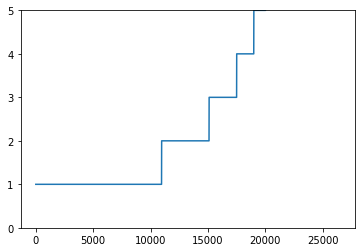

In [79]:
df_count.sum().sort_values().plot(use_index=False, ylim=(0,5))

Most of the words (10k out of 26k) of the corpus appear only once...

# Basic TF regression

https://www.tensorflow.org/text/tutorials/text_classification_rnn

In [80]:
import tensorflow as tf

In [81]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(df["excerpt"])

In [82]:
encoder(["I am testing it.", "again I am."]).numpy().shape

(2, 4)

In [83]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(dtype=tf.string, shape=(1,)),
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [84]:
model.predict(np.array(["I am testing it.", "and then why"]))

1/1 [==============================] - 3s 3s/step


array([[-0.00420023],
       [-0.00519862]], dtype=float32)

In [88]:
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [89]:
X_train, X_test, y_train, y_test = train_test_split(df["excerpt"], df["target"], test_size=0.33, random_state=42)

In [90]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
60/60 [==============================] - 26s 315ms/step - loss: 1.7821 - root_mean_squared_error: 1.3349 - val_loss: 1.4348 - val_root_mean_squared_error: 1.1978
Epoch 2/10
60/60 [==============================] - 17s 286ms/step - loss: 0.9865 - root_mean_squared_error: 0.9932 - val_loss: 0.8871 - val_root_mean_squared_error: 0.9419
Epoch 3/10
60/60 [==============================] - 18s 292ms/step - loss: 0.7847 - root_mean_squared_error: 0.8858 - val_loss: 0.7274 - val_root_mean_squared_error: 0.8529
Epoch 4/10
60/60 [==============================] - 16s 272ms/step - loss: 0.6709 - root_mean_squared_error: 0.8191 - val_loss: 0.7587 - val_root_mean_squared_error: 0.8710
Epoch 5/10
60/60 [==============================] - 19s 326ms/step - loss: 0.6236 - root_mean_squared_error: 0.7897 - val_loss: 0.6181 - val_root_mean_squared_error: 0.7862
Epoch 6/10
60/60 [==============================] - 20s 329ms/step - loss: 0.5563 - root_mean_squared_error: 0.7459 - val_loss: 0.5720 

In [91]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

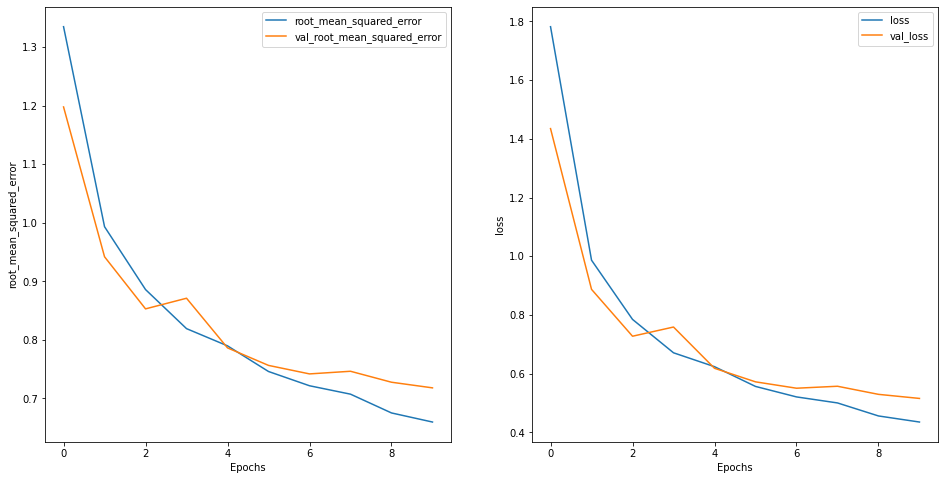

In [94]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'root_mean_squared_error')
# plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
# plt.ylim(0, None)